In [1]:
import mindspore.dataset as ds
#vision.c_transforms模块是处理图像增强的高性能模块，用于数据增强图像数据改进训练模型。
import mindspore.dataset.vision.c_transforms as CV
#c_transforms模块提供常用操作，包括OneHotOp和TypeCast
import mindspore.dataset.transforms.c_transforms as C
from mindspore.common import dtype as mstype
from mindspore import context
#导入模块用于初始化截断正态分布
from mindspore.common.initializer import TruncatedNormal
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore import Tensor
import os
import numpy as np
import matplotlib.pyplot as plt
import mindspore

In [2]:
from datetime import datetime
import json

class Logger:

    def __init__(self):
        self.log_path = \
        f'{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}_predict.json'
        # 新建log_name文件
        with open(self.log_path, 'w') as f:
            json.dump({}, f, indent=4)

    def write(self, context):
        # 读取log_name文件
        with open(self.log_path, 'r') as f:
            data = json.load(f)
        # 将context加入log文件
        data.update(context)
        with open(self.log_path, 'w') as f:
            json.dump(data, f, indent=4)


In [3]:
# 设置MindSpore的执行模式和设备
context.set_context(# mode=context.GRAPH_MODE, 
    device_target="GPU")

In [4]:
#easydict模块用于以属性的方式访问字典的值
from easydict import EasyDict as edict

cfg = edict({
    'data_path': './data/flower_photos/',
    'data_size': 3670,
    'image_width': 224,  # 图片宽度
    'image_height': 224,  # 图片高度
    'batch_size': 32,
    'channel': 3,  # 图片通道数
    'num_class': 5,  # 分类类别
    'weight_decay': 0.01,
    'lr': 0.0001,  # 学习率
    'dropout_ratio': 0.1,
    'epoch_size': 60,  # 训练次数
    'sigma': 0.01,
    'save_checkpoint_steps': 1,  # 多少步保存一次模型
    'keep_checkpoint_max': 1,  # 最多保存多少个模型
    'output_directory': './',  # 保存模型路径
    'output_prefix': "checkpoint_classification"  # 保存模型文件名字
})

In [ ]:
#从目录中读取图像的源数据集。
de_train = ds.ImageFolderDataset(cfg.data_path + r'train/',
                                 class_indexing={
                                     'daisy': 0,
                                     'dandelion': 1,
                                     'roses': 2,
                                     'sunflowers': 3,
                                     'tulips': 4
                                 })
de_test = ds.ImageFolderDataset(cfg.data_path + 'test/',
                                class_indexing={
                                    'daisy': 0,
                                    'dandelion': 1,
                                    'roses': 2,
                                    'sunflowers': 3,
                                    'tulips': 4
                                })
#解码前将输入图像裁剪成任意大小和宽高比。
transform_img = CV.RandomCropDecodeResize([cfg.image_width, cfg.image_height],
                                          scale=(0.08, 1.0),
                                          ratio=(0.75, 1.333))  #改变尺寸



#转换输入图像；形状（H, W, C）为形状（C, H, W）。
hwc2chw_op = CV.HWC2CHW()
#转换为给定MindSpore数据类型的Tensor操作。
type_cast_op = C.TypeCast(mstype.float32)
#将操作中的每个操作应用到此数据集。
de_train = de_train.map(input_columns="image",
                        num_parallel_workers=8,
                        operations=transform_img)
de_train = de_train.map(input_columns="image",
                        operations=hwc2chw_op,
                        num_parallel_workers=8)
de_train = de_train.map(input_columns="image",
                        operations=type_cast_op,
                        num_parallel_workers=8)
de_train = de_train.shuffle(buffer_size=cfg.data_size)
de_test = de_test.map(input_columns="image",
                      num_parallel_workers=8,
                      operations=transform_img)
de_test = de_test.map(input_columns="image",
                      operations=hwc2chw_op,
                      num_parallel_workers=8)
de_test = de_test.map(input_columns="image",
                      operations=type_cast_op,
                      num_parallel_workers=8)
de_test = de_test.shuffle(buffer_size=cfg.data_size)

In [6]:
#设置每个批处理的行数
#drop_remainder确定是否删除最后一个可能不完整的批（default=False）。
#如果为True，并且如果可用于生成最后一个批的batch_size行小于batch_size行，则这些行将被删除，并且不会传播到子节点。
de_train = de_train.batch(cfg.batch_size, drop_remainder=True)
#重复此数据集计数次数。
de_test = de_test.batch(cfg.batch_size, drop_remainder=True)
#get_dataset_size()获取批处理的大小。
print('训练数据集数量：', de_train.get_dataset_size() * cfg.batch_size)
print('测试数据集数量：', de_test.get_dataset_size() * cfg.batch_size)
#__next__方法处理后，获取一个batch的数据，数据格式为NCHW，第一维度为batch的数量。
data_next = de_train.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽：', data_next['image'].shape)
print('一张图像的标签样式：', data_next['label'])  # 一共5类，用0-4的数字表达类别。
print(data_next['image'][0, ...].shape)

训练数据集数量： 2944
测试数据集数量： 672
通道数/图像长/宽： (32, 3, 224, 224)
一张图像的标签样式： [4 1 1 1 4 1 4 4 4 1 0 4 2 0 2 4 1 4 1 4 3 0 2 1 2 0 4 2 1 1 4 1]
(3, 224, 224)


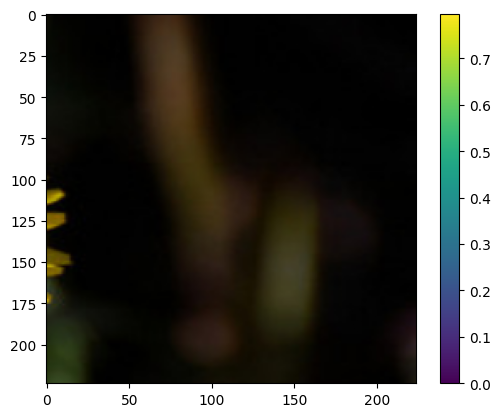

In [7]:
plt.figure()
plt.imshow(data_next['image'][1, ...].transpose(1, 2, 0) / 255)
plt.colorbar()
plt.grid(False)
plt.show()

In [8]:
# 定义网络
# 定义卷积模块并循环建立卷积层
def make_layers(struct, init_channels, batch_norm=False):
    layers = []
    in_channels = init_channels
    kernel_size = 3
    for v in struct:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels=in_channels,
                               out_channels=v,
                               kernel_size=kernel_size,
                               padding=0,
                               pad_mode='same',
                               has_bias=True,
                               weight_init='XavierUniform')
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU()]
            else:
                layers += [conv2d, nn.ReLU()]
            in_channels = v
    return nn.SequentialCell(layers)

In [9]:
# 定义VGG16网络结构
class VGG(nn.Cell):
    def __init__(self, num_class=5, channel=3, dropout_ratio=0.5, batch_norm=False):
                 super(VGG, self).__init__()
                 self.num_class = num_class
                 self.channel = channel
                 self.dropout_ratio = dropout_ratio
                 self.struct = [64, 64, 'M',
                               128, 128, 'M',
                               256, 256, 256, 'M',
                               512, 512, 512, 'M',
                               512, 512, 512, 'M']
                 self.layers = make_layers(self.struct, self.channel, batch_norm)
                 self.flatten = nn.Flatten()
                 self.classifier = nn.SequentialCell([
                     nn.Dense(512*7*7, 4096),
                     nn.ReLU(),
                     nn.Dropout(dropout_ratio),
                     nn.Dense(4096, 4096),
                     nn.ReLU(),
                     nn.Dropout(dropout_ratio),
                     nn.Dense(4096, num_class)
                 ])
                 
    def construct(self, x):
        x = self.layers(x)
        x = self.flatten(x)
        x = self.classifier(x)
        # x = x.argmax()
        return x 

In [10]:
#计算softmax交叉熵，以此作为损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

#实例化网络
net = VGG(num_class=cfg.num_class,
          channel=cfg.channel,
          dropout_ratio=cfg.dropout_ratio)
#获取网络中需要更新的参数
# print(net.trainable_params())
fc_weight_params = list(
    filter(lambda x: 'classifier' in x.name and 'weight' in x.name,
           net.trainable_params()))
other_params = list(
    filter(lambda x: 'classifier' not in x.name or 'weight' not in x.name,
           net.trainable_params()))
group_params = [{
    'params': fc_weight_params,
    'weight_decay': cfg.weight_decay
}, {
    'params': other_params
}, {
    'order_params': net.trainable_params()
}]
#设置Adam优化器，将前一步设定的需要更新的参数传入
net_opt = nn.Adam(group_params, learning_rate=cfg.lr, weight_decay=0.0)
# net_opt = nn.Adam(params=net.trainable_params(), learning_rate=cfg.lr, weight_decay=0.1)
#编译网络、损失函数和优化器
model = Model(net, loss_fn=net_loss, optimizer=net_opt, metrics={"acc"})
#设定callback监控指标
loss_cb = LossMonitor(per_print_times=de_train.get_dataset_size() * 1)
config_ck = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps,
                             keep_checkpoint_max=cfg.keep_checkpoint_max)
ckpoint_cb = ModelCheckpoint(prefix=cfg.output_prefix,
                             directory=cfg.output_directory,
                             config=config_ck)

In [11]:
CKPT = "./checkpoint_classification_1-10_92.ckpt"
#将参数加载进网络
load_checkpoint(CKPT, net=net)
#编译网络、损失函数和优化器
model = Model(net, loss_fn=net_loss, optimizer=net_opt, metrics={"acc"})
metric = model.eval(de_test)
print(metric)

{'acc': 0.49107142857142855}


In [12]:
logger = Logger()
logger.write({"Metrics": metric})
logger.write({"model": str(net)})
logger.write({"filename": CKPT})

In [17]:
class_names = {
    0: 'daisy',
    1: 'dandelion',
    2: 'roses',
    3: 'sunflowers',
    4: 'tulips'
}
#获取测试集的batch
test_ = de_test.create_dict_iterator().__next__()
#转换为tensor
test = Tensor(test_['image'], mindspore.float32)
#预测
predictions = model.predict(test)
predictions = predictions.asnumpy()
true_label = test_['label'].asnumpy()

In [ ]:
#显示预测结果
for i in range(9):
    p_np = predictions[i, :]
    pre_label = np.argmax(p_np)
    print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '真实结果：',
          class_names[true_label[i]])